In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from sklearn.utils import shuffle
import re
import string 
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import cufflinks as cf
import plotly
import plotly.express as px
import seaborn as sns
from IPython.core.display import HTML
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame
from plotly.offline import iplot
from collections import OrderedDict 
from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

In [2]:
fake = pd.read_csv("C:/Users/rmani/Desktop/Python/Projet/Fake.csv", sep=',')
true = pd.read_csv("C:/users/rmani/Desktop/Python/Projet/True.csv", sep=',')

In [3]:
fake.size, true.size

(93924, 85668)

In [4]:
fake['text'][10]

"A centerpiece of Donald Trump s campaign, and now his presidency, has been his white supremacist ways. That is why so many of the public feuds he gets into involve people of color. One of his favorite targets, is, of course, the players in the National Football League who dare to exercise their First Amendment rights by kneeling during the national anthem in protest of racist police brutality. Well, there is one person who has figured out that racism is bad for business, even if it did get the orange overlord elected: The founder of the pizza chain Papa John s.This is a man who has never been on the right side of history on any number of issues, and plus his pizza sucks. But, when he decided to complain about the players protesting, his sales really dropped. Turns out racism doesn t pay, and we all know that corporations are all about the bottom line. Therefore, Papa John Schnatter will no longer be CEO of the hack pizza chain.BREAKING: Papa John's founder John Schnatter to step down 

In [5]:
#Concaténation des deux df
fake=fake.assign(fake_news=1)
true=true.assign(fake_news=0)

df=pd.concat([fake,true])

In [6]:
#df=df.iloc[1:100]

In [7]:
df.size

224490

In [8]:
df.head()

,title,text,subject,date,fake_news
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [9]:
#Nb de valeurs manquantes dans le dataframe
df.isnull().sum()

title        0
text         0
subject      0
date         0
fake_news    0
dtype: int64

In [10]:
# des doublons?
duplicateRowsDF = df[df.duplicated()]

C:\Users\rmani\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='fake_news', ylabel='count'>

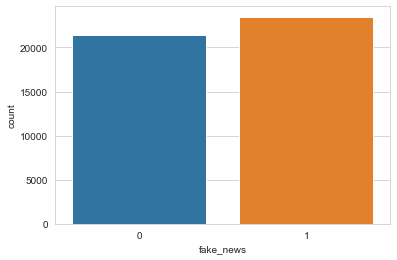

In [11]:
fake_news = df['fake_news']
sns.set_style('whitegrid')
sns.countplot(fake_news)

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64


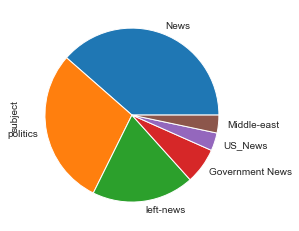

In [12]:
# Thèmes dans les fakes news

print(fake.subject.value_counts())
fake.subject.value_counts().plot(kind='pie') ;

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64


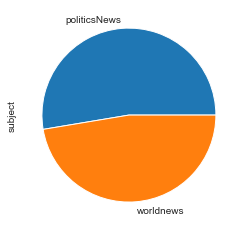

In [13]:
# Thèmes dans les vrais news

print(true.subject.value_counts())
true.subject.value_counts().plot(kind='pie') ;

In [ ]:
df['date'] = df['date'].astype(str)
df['date'] = df['date'].str.strip()
df['date'] = df['date'].str.replace(",","")
df['date'] = df['date'].str.replace(" ","-")

df = df[~df['date'].str.contains('\.')]
df = df[~df['date'].str.contains('\[')]

df[['month','day','year']] = df['date'].str.split('-',expand=True)

df.drop(df[df.month == "14"].index, inplace=True)
df.drop(df[df.month == "15"].index, inplace=True)
df.drop(df[df.month == "16"].index, inplace=True)
df.drop(df[df.month == "17"].index, inplace=True)
df.drop(df[df.month == "18"].index, inplace=True)
df.drop(df[df.month == "19"].index, inplace=True)

df['month'] = [x[:3] for x in df['month']]

df["date"] = df.month.apply(str).str.cat(others=[df.day, df.year], sep='-')

df.drop(['month','day','year'], axis=1, inplace=True)

df["date"] = pd.to_datetime(df['date']).dt.strftime('%d-%m-%Y')
df["date"]

In [ ]:
df.groupby(df["date"].dt.month).count().plot(kind="bar")

In [14]:
# On uniformise le texte en minuscule
df['text'] = df['text'].apply(lambda x: x.lower())

In [15]:
# On mélange nos données
df=shuffle(df).reset_index(drop=True)

In [16]:
# On retire les ponctuations ?

#Note : on pourrait pas les utiliser ?

def remove_punct(_str):
  _str = re.sub('['+string.punctuation+']', ' ', _str)
  _str = re.sub('[\r]', ' ', _str)
  _str = re.sub('[\n]', ' ', _str)
  return _str

df['text'] = df['text'].apply(remove_punct)

In [17]:
# On exclue les stopwords en anglais 

stop_words=stopwords.words('english')
df["text_without_stopwords"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [18]:
# Termes les plus représenter 
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [19]:
cf.go_offline() 

In [20]:
common_words = get_top_n_words(df['text_without_stopwords'], 20)
df2 = DataFrame (common_words,columns=['word','count'])
df2.groupby('word').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 unigrams used in articles',color='blue')

In [21]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [22]:
common_words = get_top_n_bigram(df['text_without_stopwords'], 20)
df3 = pd.DataFrame(common_words, columns = ['words' ,'count'])
df3.groupby('words').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams used in articles', color='blue')

In [23]:
# On transformer notre texte en plusieurs mots séparés par des espaces.
df['tokenized_text'] = df.apply(lambda row: word_tokenize(row['text_without_stopwords']), axis=1)

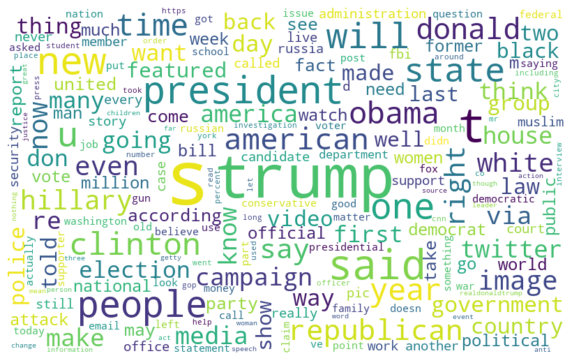

In [24]:
# Nuage de mots pour les fake news

df_fake = df[df["fake_news"] == 1]
collect_words = ' '.join([txt for txt in df_fake.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False,background_color="white").generate(collect_words)
plot.figure(figsize=(10,7))
plot.imshow(wordcloud, interpolation='bilinear')
plot.axis("off")
plot.show()

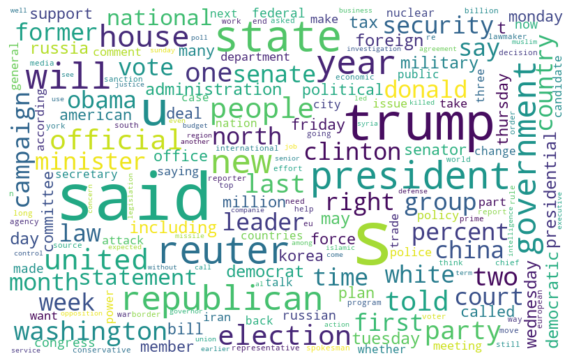

In [25]:
# Nuage de mots pour les true news

df_true = df[df["fake_news"] == 0]
collect_words = ' '.join([txt for txt in df_true.text])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False,background_color="white").generate(collect_words)
plot.figure(figsize=(10,7))
plot.imshow(wordcloud, interpolation='bilinear')
plot.axis("off")
plot.show()

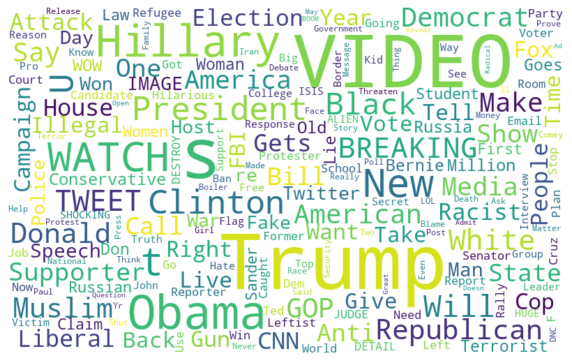

In [26]:
#Peut être plus intéressant sur les titles ?

#Nuage de points sur les titres fake

df_fake_title = df[df["fake_news"] == 1]
collect_words = ' '.join([txt for txt in df_fake.title])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False,background_color="white").generate(collect_words)
plot.figure(figsize=(10,7))
plot.imshow(wordcloud, interpolation='bilinear')
plot.axis("off")
plot.show()

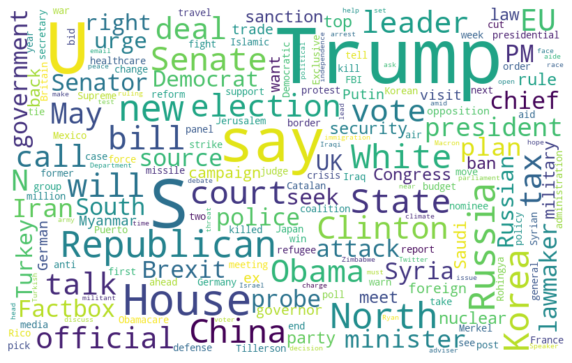

In [27]:
#Nuage de points sur les titres true

df_true_title = df[df["fake_news"] == 0]
collect_words = ' '.join([txt for txt in df_true.title])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False,background_color="white").generate(collect_words)
plot.figure(figsize=(10,7))
plot.imshow(wordcloud, interpolation='bilinear')
plot.axis("off")
plot.show()

In [28]:
# Plus intéressants de faire le nuage sur les titres j'ai l'impression
# Intéressant aussi de pas enlever les majuscules, on voit direct le côté exclamatif 
# VIDEO, WATCH, lie, Attack, Terrorist : on voit quand même une diff de type de mots qui ressortent

In [33]:
x = df["text_without_stopwords"]
y = df["fake_news"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)


RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)
pred_rfc = RFC.predict(xv_test)

RFC.score(xv_test, y_test)

print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5403
           1       1.00      0.99      1.00      5822

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225

